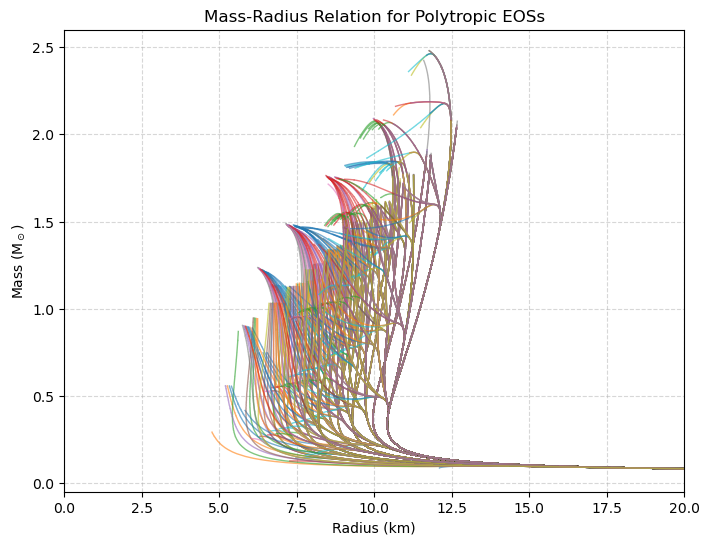

In [1]:
import matplotlib.pyplot as plt
import csv
import glob

files = glob.glob("polytropic_main/TOV_results/*TOV.csv")

plt.figure(figsize=(8,6))
for file in files:
    masses, radii = [], []
    with open(file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            mass_km = float(row['Mass'])
            radius_km = float(row['Radius'])
            mass_Msun = mass_km 
            masses.append(mass_Msun)
            radii.append(radius_km)
    plt.plot(radii, masses, alpha=0.6, lw=1)

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M$_\odot$)")
plt.title("Mass-Radius Relation for Polytropic EOSs")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.xlim(0, 20)
plt.show()


<>:21: SyntaxWarning: invalid escape sequence '\o'
<>:21: SyntaxWarning: invalid escape sequence '\o'
C:\Users\vasil\AppData\Local\Temp\ipykernel_14748\475514301.py:21: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("Mass (M$_\odot$)")


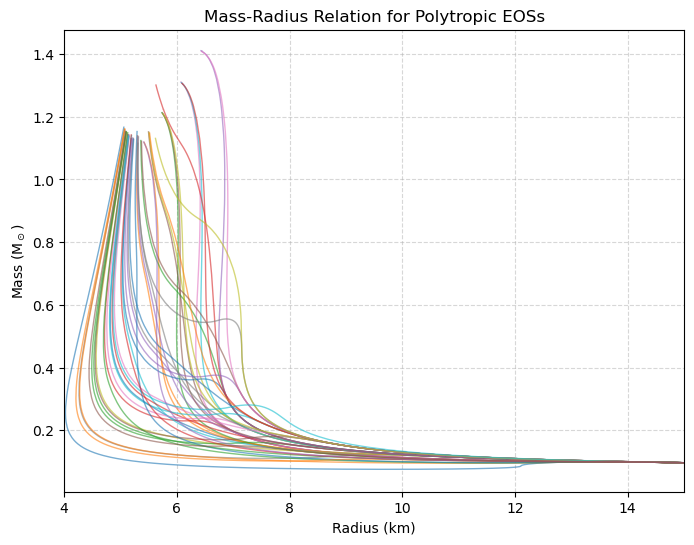

In [16]:
import matplotlib.pyplot as plt
import csv
import glob

files = glob.glob("polytropic_main/TOV_results_1_2_3_4/*TOV.csv")

plt.figure(figsize=(8,6))
for file in files:
    masses, radii = [], []
    with open(file, 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            mass_km = float(row['Mass'])
            radius_km = float(row['Radius'])
            mass_Msun = mass_km 
            masses.append(mass_Msun)
            radii.append(radius_km)
    plt.plot(radii, masses, alpha=0.6, lw=1)

plt.xlabel("Radius (km)")
plt.ylabel("Mass (M$_\odot$)")
plt.title("Mass-Radius Relation for Polytropic EOSs")
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.xlim(4, 15)
plt.show()


<>:53: SyntaxWarning: invalid escape sequence '\g'
<>:53: SyntaxWarning: invalid escape sequence '\g'
C:\Users\vasil\AppData\Local\Temp\ipykernel_8808\3861861027.py:53: SyntaxWarning: invalid escape sequence '\g'
  ax.set_title(f"$\gamma_1$ = {gamma_1}", fontsize=14)


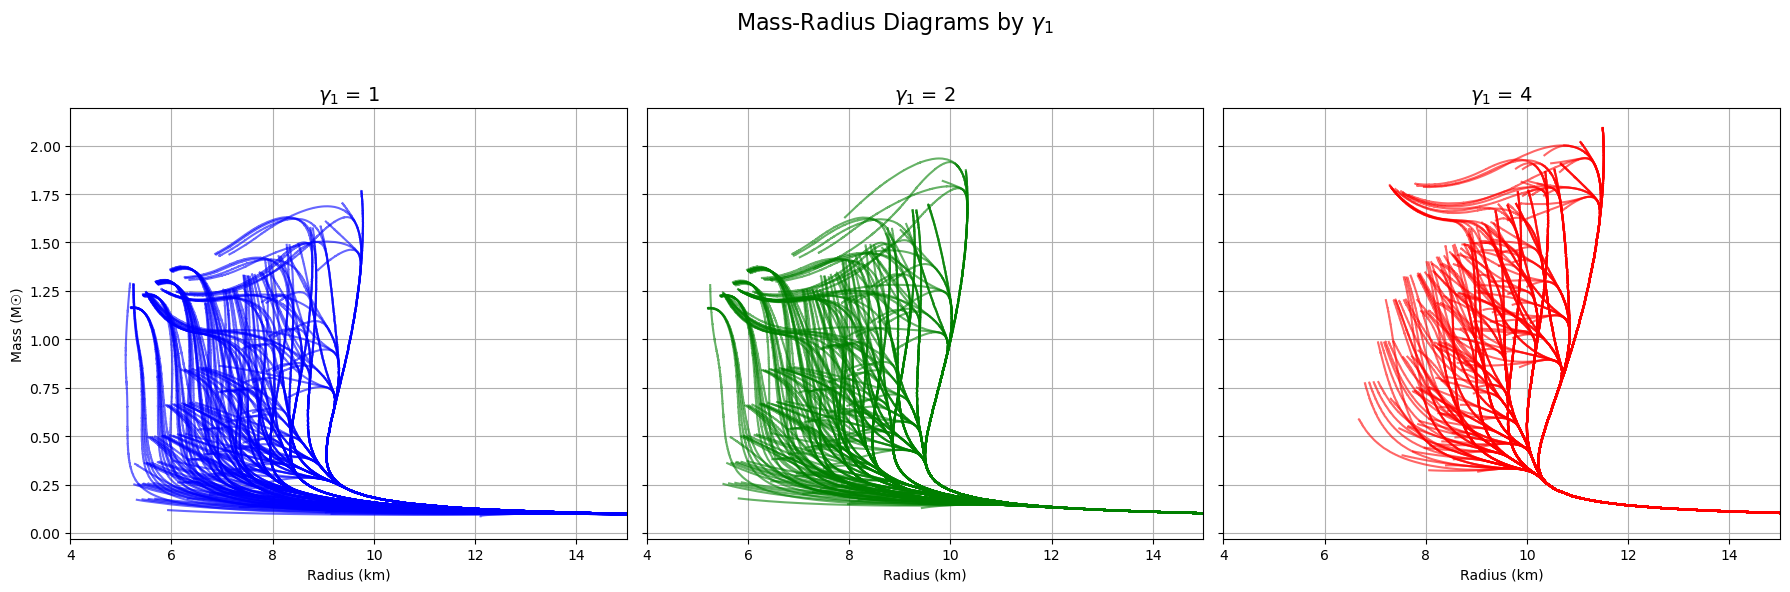

In [11]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

# ---- Configuration ----

gamma_options = [1, 2, 4]
segments = 6
results_folder = "polytropic_main/TOV_results_1_2_3_4"

# Color map for consistency (can also use per-subplot color if preferred)
gamma_colors = {
    1: 'blue',
    2: 'green',
    4: 'red'
}

# Map EOS index to gamma_1
def get_gamma1_from_filename(filename):
    index = int(filename.split("_")[1])
    all_gamma_paths = list(product(gamma_options, repeat=segments))
    return all_gamma_paths[index - 1][0]  # gamma_1

# ---- Organize Files by gamma_1 ----

files_by_gamma1 = {g: [] for g in gamma_options}

for filepath in sorted(glob.glob(os.path.join(results_folder, "*TOV.csv"))):
    filename = os.path.basename(filepath)
    gamma_1 = get_gamma1_from_filename(filename)
    files_by_gamma1[gamma_1].append(filepath)

# ---- Create Subplots ----

num_gammas = len(gamma_options)
fig, axs = plt.subplots(1, num_gammas, figsize=(6 * num_gammas, 6), sharey=True)

if num_gammas == 1:
    axs = [axs]  # in case only one subplot

for ax, gamma_1 in zip(axs, gamma_options):
    color = gamma_colors[gamma_1]
    for filepath in files_by_gamma1[gamma_1]:
        data = np.genfromtxt(filepath, delimiter=',', skip_header=1)
        if data.ndim != 2 or data.shape[0] == 0:
            continue
        M_vals = data[:, 0]
        R_vals = data[:, 1]
        ax.plot(R_vals, M_vals, color=color, alpha=0.6)

    ax.set_title(f"$\gamma_1$ = {gamma_1}", fontsize=14)
    ax.set_xlabel("Radius (km)")
    ax.grid(True)
    ax.set_xlim(4, 15)

axs[0].set_ylabel("Mass (M☉)")
fig.suptitle("Mass-Radius Diagrams by $\\gamma_1$", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig(os.path.join(results_folder, "MR_diagram_subplots_by_gamma1.png"))
plt.show()
